## TRATAMIENTO DE SERIES DE TIEMPO. KIT PARA TRADERS

In [1]:
import pandas as pd
import pandas_datareader as dr
# datareader nos da acceso a muchas apis de datos economicos ver mas en 
# https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
import numpy as np
import matplotlib.pyplot as plt
# para que los graficos molen mas
plt.style.use('seaborn-darkgrid')

In [2]:
#seleccionamos el activo a estudiar
from datetime import date
Activo = 'SPY'
# establecemos las fechas que son paremetros necesarios
FechaInicio = '01-01-1993'
FechaFinal = '11-01-2019'
# podríamos usar para fecha de hoy  date.today()
#Descargamos la serie y echamos un vistazo
df = dr.data.get_data_yahoo(Activo, start=FechaInicio, end=FechaFinal)
# parece interesante elimitar duplicados en el index, fechas, por
# problemas con criptomonedas, no sé bien porqué
df = df[~df.index.duplicated()]
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-10-28,303.850006,302.910004,302.940002,303.299988,42147000.0,296.283051
2019-10-29,304.230011,302.859985,303.000000,303.209991,44284900.0,296.195160
2019-10-30,304.549988,301.989990,303.429993,304.140015,49643900.0,297.103668
2019-10-31,304.130005,301.730011,304.130005,303.329987,69053800.0,296.312378
2019-11-01,306.190002,304.739990,304.920013,306.140015,71141500.0,299.057404


In [3]:
# vamos a anadir una columna con los returns
df['returns'] = df['Adj Close'].pct_change()
df.head()

,High,Low,Open,Close,Volume,Adj Close,returns
Date,,,,,,,
1993-01-29,43.96875,43.75000,43.96875,43.93750,1003200.0,25.968958,NaN
1993-02-01,44.25000,43.96875,43.96875,44.25000,480500.0,26.153660,0.007112
1993-02-02,44.37500,44.12500,44.21875,44.34375,201300.0,26.209057,0.002118
1993-02-03,44.84375,44.37500,44.40625,44.81250,529400.0,26.486113,0.010571
1993-02-04,45.09375,44.46875,44.96875,45.00000,531500.0,26.596937,0.004184


/Users/carlosoterofernandez/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


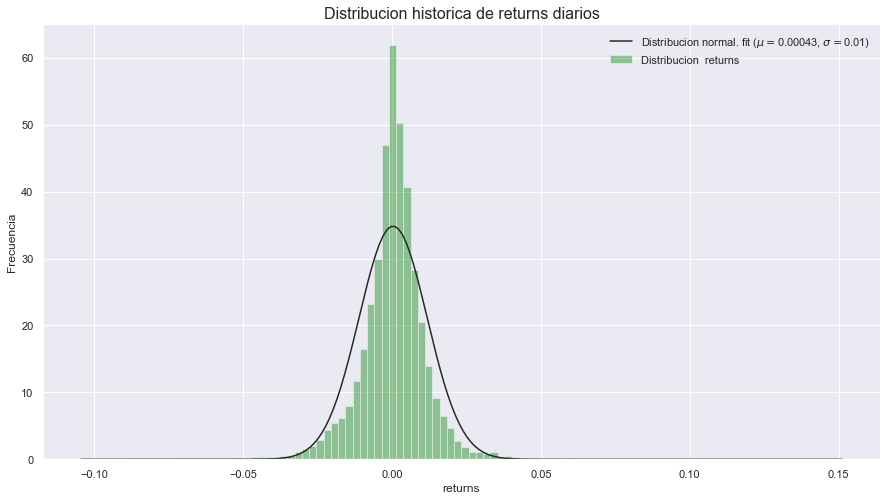

In [4]:
# vamos a ver la funcion de densidad de probabilidad de los returns
# a ver si se ajustan a una distribucion normal
import seaborn as sns
from scipy import stats
from scipy.stats import norm

#elimitamos la primera linea que contiene un NaN en los returns
df = df.dropna()

#dibujamos el histograma de frecuencias
plt.figure(figsize=(15,8))
sns.set(color_codes = True)
ax = sns.distplot(df['returns'], bins=100, kde=False,
    fit=stats.norm,color='green')
#obtenemos los parametros ajustados a la distrib normal utilizados por sns
(mu, sigma) = stats.norm.fit(df['returns'])

# configuramos el grafico
plt.title('Distribucion historica de returns diarios', fontsize=16)
plt.ylabel('Frecuencia')
plt.legend(['Distribucion normal. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})'.format(mu,sigma), 'Distribucion  returns'])

#### 
El histograma consta de un eje-x (horizontal) y de un eje-y (vertical).  En nuestro caso, las barras verdes del histograma muestran la frecuencia (eje-y) con la que los retornos aritméticos se sitúan dentro de un determinado rango de valores del eje-x. La línea negra muestra la FDP de la distribución normal teórica. Dicha distribución se computa utilizando el promedio y la desviación típica de nuestra serie de retornos histórica.
Aquí podemos ver que nuestra distribución de retornos tiene cierta similitud con una distribución normal, sin embargo, esta no llega a ajustarse perfectamente. En realidad, las series de retornos que nos encontramos en los mercados rara vez, si no nunca, se ajustan perfectamente a una distribución normal. En general tienden a mostrar valores extremos que se desvían de su media con una probabilidad más alta de lo que se espera en una distribución normal. Lo cual produce distribuciones con colas largas y por ende mayor probabilidad de sufrir riesgo de cola (Tail Risk). El coeficiente de asimetría y la curtosis nos sirven para saber cuánto se desvía nuestra distribución de una distribución normal teórica. Obtendremos estos dos valores más adelante.
En el análisis de las series temporales financieras, por simplificación, se parte de la asunción de que las series de precios se ajustan a una distribución normal.  El principal problema que surge con esta teoría es que subestima el riesgo de obtener valores extremos. Es decir, si asumimos que la distribución es normal y en realidad sus colas son más largas de lo normal,  las probabilidades de obtener valores extremos serán más altas de lo esperado. Por ello, cuando esto ocurre resulta necesario descartar la normalidad, e utilizar herramientas más eficientes para medir el riesgo. Entre las cuales tenemos el VaR o el CVaR aplicando el método de cálculo histórico.
A continuación vamos a añadir el siguiente bloque de código para obtener la estadística descriptiva de los retornos. Aquí hemos añadido los estadísticos que considero más importantes, si queremos podremos personalizar este apartado añadiendo aquellos otros que consideremos. Dentro del código encontraremos comentarios que nos indican para qué sirven las distintas instrucciones:


In [5]:
# calculamos tasa crecimiento anual compuesto, es el resultado de comprar y mantener

Años = df['returns'].count() / 252
# tb podriamos decir df['returns'].shape[0]
CAGR = (df['Adj Close'].iloc[-1] / df['Adj Close'].iloc[0]) ** (1/Años) -1

print(50*'=')
print('> Tasa de crecimiento Anual Compuesto:', '%.6s' % (100 * CAGR),'%')
print('> Buy and Hold:', '%.6s' % (100*((df['Adj Close'].iloc[-1] -
                                        df['Adj Close'].iloc[0]) /
                                        df['Adj Close'].iloc[0])), '%')

# Calculamos el máximo Drawdown
Maximo_Anterior = df['Adj Close'].cummax()
drawdowns = 100*((df['Adj Close'] - Maximo_Anterior ) / Maximo_Anterior)
DD = pd.DataFrame({'Adj Close': df['Adj Close'],
                   'Previous Peak': Maximo_Anterior,
                   'Drawdown': drawdowns})
print('> Máximo Drawdown Histórico:', '%.6s' % np.min(DD['Drawdown']), '%')

# Obtenemos el promedio, desviación típica, máximo y mínimo y nº muestral
print('> Media Diaria:', '%.6s' % (100 * df['returns'].mean()), '%')
print('> Desviación Típica Diaria:', '%.6s' % (100 * df['returns'].std(ddof=1)), '%')
print('> Máxima Pérdida Diaria:', '%.6s' % (100 * df['returns'].min()), '%')
print('> Máximo beneficio Diario:', '%.6s' % (100 * df['returns'].max()), '%')
print('> Días Analizados:', '%.6s' % (df['returns'].shape[0]))
print(50*'=')

# Coeficientes de asimetría y curtósis de la distribución
print('> Coeficiente de asimetría:', '%.6s' % df['returns'].skew())
print('> Curtosis:', '%.6s' % df['returns'].kurt())
print(50*'=')

# VaR Teórico obtenido a través de la distribución normal al 95% y 99%
print('> VaR Modelo Gaussiano NC-95% :', '%.6s' % (100 * norm.ppf(0.05, mu, sigma)), '%')
print('> VaR Modelo Gaussiano NC-99% :', '%.6s' % (100 * norm.ppf(0.01, mu, sigma)), '%')
print('> VaR Modelo Gaussiano NC-99.7% :', '%.6s' % (100 * norm.ppf(0.003, mu, sigma)), '%')

# VaR histórico al 95% y 99% de confianza
print('> VaR Modelo Histórico NC-95% :', '%.6s' % (100 * np.percentile(df['returns'], 5)), '%')
print('> VaR Modelo Histórico NC-99% :', '%.6s' % (100 * np.percentile(df['returns'], 1)), '%')
print('> VaR Modelo Histórico NC-99.7% :', '%.6s' % (100 * np.percentile(df['returns'], 0.3)), '%')
print(50*'=')

> Tasa de crecimiento Anual Compuesto: 9.5396 %
> Buy and Hold: 1043.4 %
> Máximo Drawdown Histórico: -55.18 %
> Media Diaria: 0.0428 %
> Desviación Típica Diaria: 1.1451 %
> Máxima Pérdida Diaria: -9.844 %
> Máximo beneficio Diario: 14.519 %
> Días Analizados: 6739
> Coeficiente de asimetría: 0.0723
> Curtosis: 11.082
> VaR Modelo Gaussiano NC-95% : -1.840 %
> VaR Modelo Gaussiano NC-99% : -2.620 %
> VaR Modelo Gaussiano NC-99.7% : -3.103 %
> VaR Modelo Histórico NC-95% : -1.808 %
> VaR Modelo Histórico NC-99% : -3.107 %
> VaR Modelo Histórico NC-99.7% : -4.564 %


<AxesSubplot:xlabel='Date'>

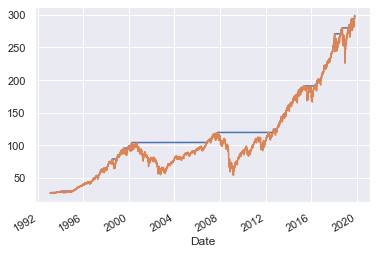

In [6]:
#por curiosidad vamos a ver el gráfico de Previous Peak y de returns
Maximo_Anterior.plot()
df['Adj Close'].plot()

<AxesSubplot:xlabel='Date'>

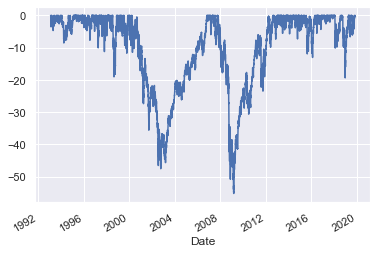

In [7]:
# y tb vamos a ver el gráfico del drawdown
drawdowns.plot()

#### 
En el primer apartado tenemos los estadísticos básicos de la serie; tasa de crecimiento anual compuesta, resultado de la “estrategia” Buy & Hold, máximo Drawdown histórico, etc.
En el apartado inferior tenemos el coeficiente de asimetría y el coeficiente de curtosis. Ambos sirven para conocer cómo se distribuyen los retornos en nuestra distribución, y cuanto se desvían de una distribución normal.
El coeficiente de asimetría (skewness) mide la asimetría de la distribución de los retornos sobre su media. Este valor puede ser positivo, negativo o neutro. En una distribución normal el coeficiente de asimetría es 0 ya que ambas colas están simétricamente balanceadas. En nuestra distribución este valor es positivo lo cual indica que la cola derecha es más larga que la izquierda. Dicho de otro modo, en la cola derecha encontramos valores más alejados de la media que en la cola izquierda. Lo cual en este caso particular es positivo.
La curtosis (Kurtosis) define en qué  grado las colas de la distribución difieren de las colas de una distribución normal. En una distribución normal la curtosis es 3. En nuestra distribución este valor es superior, lo cual nos indica que las colas son más largas de lo que se espera en una distribución normal. Dicho de otro modo, nos indica que nuestra distribución contiene valores que exceden las 3 desviaciones típicas de la media, las cuales no son excedidas con una probabilidad del 99.7% en una distribución normal. Cuando la curtosis excede la normalidad se dice que la distribución es leptocúrtica.
Tras analizar ambos coeficientes vemos que la serie no se ajusta totalmente a la normalidad. Vamos a ver ahora cuál es la limitación de estimar el riesgo de la serie asumiendo que sigue una distribución normal.
En el último apartado de las estadísticas tenemos el VaR (Value at Risk) calculado de dos modos distintos: En el primer caso se utiliza el modelo gaussiano, el cual asume que los retornos están normalmente distribuidos. En el segundo caso se utiliza el modelo basado en datos históricos, en el que se utiliza la distribución empírica, y en el que no se hacen asunciones sobre el tipo de distribución de la serie. En ambos casos se obtiene cuál es la peor pérdida esperada con un nivel de confianza del 95%, 99% y 99.7%.
Aquí se observa que con un nivel de confianza del 95% ambos métodos obtienen un valor muy similar, sin embargo, al 99%  y al 99.7% las diferencias son notables. En ambos casos el resultado esperado en el modelo empírico es peor que en el modelo gaussiano, lo cual nos confirma nuevamente que la cola izquierda de nuestra distribución es más larga que la normal.
Análisis de volatilidad
Vamos a analizar ahora la volatilidad histórica de nuestra serie temporal. Principalmente nos interesa conocer la evolución de la volatilidad durante todo el periodo. El código inferior nos sirve para crear un gráfico que muestra la evolución de los siguientes tres valores:
Volatilidad anualizada: Desviación típica de los últimos 14 días multiplicada por la raíz cuadrada de 252.
Media aritmética sobre la volatilidad anualizada (SMA): Muestra el promedio de los últimos 126 valores de la volatilidad anualizada.
Precio de cierre de ajustado.
Dentro del siguiente bloque de código encontraremos diferentes comentarios que explican la utilidad de las distintas instrucciones:

## Volatilidad
Vamos a analizar ahora la volatilidad histórica de nuestra serie temporal. Principalmente nos interesa conocer la evolución de la volatilidad durante todo el periodo. 
El código inferior nos sirve para crear un gráfico que muestra la evolución de los siguientes tres valores:

-Volatilidad anualizada: Desviación típica de los últimos 14 días multiplicada por la raíz cuadrada de 252.

-Media aritmética sobre la volatilidad anualizada (SMA): Muestra el promedio de los últimos 126 valores de la volatilidad anualizada.

-Precio de cierre de ajustado.

Dentro del siguiente bloque de código encontraremos diferentes comentarios que explican la utilidad de las distintas instrucciones:

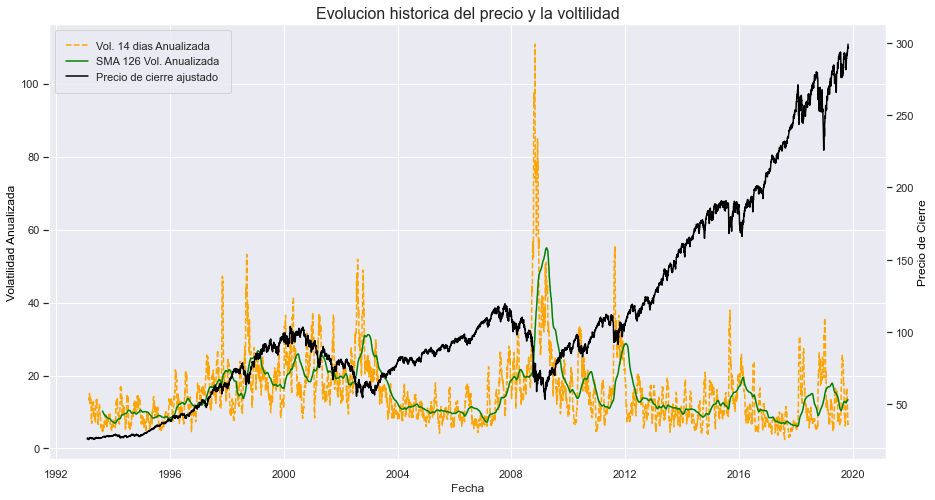

In [10]:
import matplotlib.pyplot as plt

#Volatilidad historica de 14 dias, la misma volatilidad anualizada y la media aritmetica de la 
# volatilidad anualizada calculada sobre los 126 valores precedentes
df['Volatilidad_Historica_14_dias'] = 100*df['returns'].rolling(14).std()
df['Volatilidad_14_dias_Anualizada'] = df['Volatilidad_Historica_14_dias']*(252**0.5)
df['SMA_126_Volatilidad_Anualizada'] = df['Volatilidad_14_dias_Anualizada'].rolling(126).mean()

# Creamos una figura con eje x e y
fig, ax1 = plt.subplots(figsize=(15,8))
# creamos un eje y apuesto con otra escala para una de las graficas y que se vean todas proporcionales
ax2 = ax1.twinx()

#creamos los objetos que vamos a dibujar en los ejes ax1 y ax2
volatilityLine = ax1.plot(df['Volatilidad_14_dias_Anualizada'], 
                          'orange', linestyle='--', label='Vol. 14 dias Anualizada')
smaLine = ax1.plot(df['SMA_126_Volatilidad_Anualizada'], 'green', linestyle='-', 
                  label= 'SMA 126 Vol. Anualizada')
adjustedCloseLine = ax2.plot(df['Adj Close'], 'black', label='Precio de cierre ajustado')

#Titulo del grafico
plt.title('Evolucion historica del precio y la voltilidad', fontsize=16)

#Etiquetas de los ejes x e y
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Volatilidad Anualizada', color='black')
ax2.set_ylabel('Precio de Cierre', color='black')

#creamos una lista con los diferentes plots para crear un cuadro con los labels
plotLines = volatilityLine + smaLine + adjustedCloseLine
# Creamos una njueva lista extrajendo las etiquietas de cada plot
labels = [line.get_label() for line in plotLines]
# En la leyenda incluimos la lista de plots y las etiquetas de cada plot
ax1.legend(plotLines, labels, loc='upper left', frameon=True, borderpad=1)

ax1.grid(True)
ax2.grid(False)

plt.show()